In [1]:
import networkx as nx
import itertools
import pandas as pd
import numpy as np
from stellargraph import StellarGraph
from rdkit.Chem import AllChem, DataStructs
import json
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras
import tensorflow as tf

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression, link_classification
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision
#mixed_precision.set_global_policy('float32')

2023-07-04 15:34:30.308708: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 15:34:33.899462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
g = nx.read_graphml("./graph/test_graph.gml")
species_features_dummy = pd.read_csv("./data/species_features.csv.gz", index_col=0)
#species_features_dummy = pd.read_csv("./data/species_BaseNEncoder.csv.gz", index_col=0)
#species_features_dummy = pd.read_csv("./data/species_Multi_dim_scale.csv.gz", index_col=0)
molecule_features_dummy = pd.read_csv("./data/molecule_features.csv.gz", index_col=0).astype("int8")
df_agg = pd.read_csv("./data/lotus_agg_test.csv.gz", index_col=0)
#molecule_features_dummy = pd.read_csv("./data/molecule_features_dummy.csv.gz", index_col=0).astype('int8')

In [3]:
species_feat = species_features_dummy[species_features_dummy.index.isin(df_agg.organism_name)]
molecule_feat = molecule_features_dummy[molecule_features_dummy.index.isin(df_agg.structure_smiles_2D)]

In [4]:
df_agg_train = pd.read_csv("./data/lotus_agg_train.csv.gz", index_col=0)

In [5]:
species_unique_to_test_set = df_agg[~df_agg.organism_name.isin(df_agg_train.organism_name)]
molecules_unique_to_test_set = df_agg[~df_agg.structure_smiles_2D.isin(df_agg_train.structure_smiles_2D)]

In [6]:
g_train = nx.read_graphml("./graph/train_graph.gml")

In [7]:
g = nx.create_empty_copy(g)
g_merged = nx.compose(g_train, g)

In [8]:
#g = nx.create_empty_copy(g)
G = StellarGraph.from_networkx(g_merged,
                               node_features={'species': species_features_dummy,
                                              'molecule':molecule_features_dummy})

In [9]:
print(G.info())
G.check_graph_for_ml()

StellarDiGraph: Directed multigraph
 Nodes: 184990, Edges: 700916

 Node types:
  molecule: [148190]
    Features: float32 vector, length 27
    Edge types: molecule-present_in->species
  species: [36800]
    Features: float32 vector, length 80
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [350458]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [350458]
        Weights: all 1 (default)
        Features: none


In [10]:
model = tf.keras.models.load_model("./model/batch_128_layer_1024", compile=True)

In [11]:
species_unique_to_test_set = species_unique_to_test_set[['structure_smiles_2D', 'organism_name']].to_numpy()

In [12]:
test_flow = HinSAGELinkGenerator(G,
                                 batch_size=128,
                                num_samples=[3,1],
                                head_node_types=["molecule", "species"]).flow(species_unique_to_test_set,
                                                                              np.ones(len(species_unique_to_test_set)).reshape(-1,1))

In [13]:
def predict(model, flow, iterations=10):
    predictions = []
    for _ in range(iterations):
        predictions.append(model.predict(flow, workers=-1).flatten())

    return np.mean(predictions, axis=0)

In [14]:
result = predict(model, test_flow)

14/14 [==============================] - 0s 21ms/step


In [15]:
sum(result>0.5)/len(result)

0.32668187001140253

Text(0.5, 1.0, 'Test on unknown SPECIES but known MOLECULES')

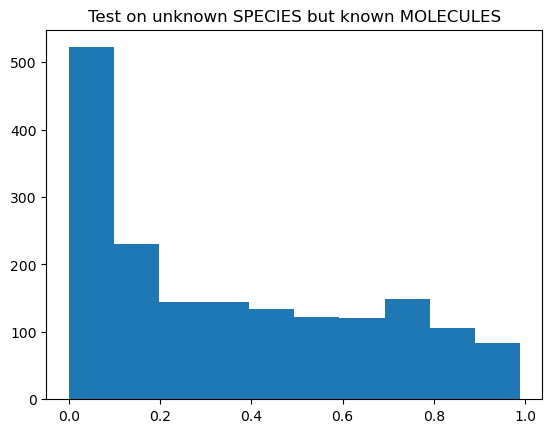

In [44]:
plt.hist(result)
plt.title("Test on unknown SPECIES but known MOLECULES")

In [17]:
test = result[(result>0.9) | (result<0.1)]
test = test>0.5
test = test.astype('int8')

In [18]:
molecules_unique_to_test_set = molecules_unique_to_test_set[['structure_smiles_2D', 'organism_name']].to_numpy()

In [19]:
test_flow_mol = HinSAGELinkGenerator(G,
                                 batch_size=128,
                                num_samples=[3,1],
                                head_node_types=["molecule", "species"]).flow(molecules_unique_to_test_set,
                                                                              np.ones(len(molecules_unique_to_test_set)).reshape(-1,1))

In [41]:
out_mol = predict(model, test_flow_mol)

174/174 [==============================] - 3s 15ms/step


Text(0.5, 1.0, 'Test on unknown MOLECULES but known SPECIES')

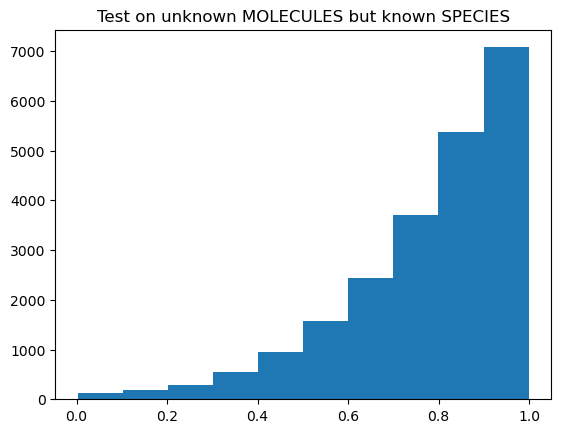

In [45]:
plt.hist(out_mol)
plt.title("Test on unknown MOLECULES but known SPECIES")

In [48]:
sum(out_mol>0.5)/len(out_mol)

0.906826153431064

In [49]:
molecules_unique_to_test_set

array([['CC=CC1C=CC2CC(CO)CCC2C1(C)C(O)=C1C(=O)NC(C)(C(C)O)C1=O',
        'Cordyceps farinosa'],
       ['CC(=O)C(C)=CC=CC(C)=CC=CC=C(C)C=CC=C(C)C=CC1=C(C)CC(O)CC1(C)C',
        'Persea americana'],
       ['CC1OC(Oc2cc(O)c3c(=O)c(O)c(-c4ccc(OC5OC(C)C(O)C(O)C5OC5OCC(O)C(O)C5O)cc4)oc3c2)C(O)C(O)C1O',
        'Chenopodium murale'],
       ...,
       ['COc1cc(CC2(O)COC(c3ccc(OC)c(OC)c3)C2(O)CO)ccc1O',
        'Abies nephrolepis'],
       ['CCCCCCCCCC(Cl)CCCCCc1cc(OC2OC(C)C(O)C(O)C2O)c(CCCCCC(Cl)CCCCCC)c(O)c1C1OCC(O)C(O)C1O',
        'Nodosilinea'],
       ['COc1cc(C2CC(=O)c3c(cc(OC)c(OC)c3O)O2)cc(O)c1OC',
        'Greigia sphacelata']], dtype=object)

In [50]:
out_mol

array([0.86960304, 0.5044888 , 0.80732995, ..., 0.79468596, 0.80384654,
       0.3815122 ], dtype=float32)

## Discussion

It seems like the model predicts well new molecules on known species but if new species are added, it is not able to predict which molecules will be present. 

This seems to be due to the fact that the model has been trained to predict on edges `present_in` in a "directed" way. So if the model has a new molecule, it takes its embeddings and is able to predict weather that molecule will be present or not.

I will try to create an other model that predicts the edges on `has` type. I expect it to have the opposite result. 